<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

# ebablbe auto-completion
%config Completer.use_jedi = False

Tensorflow version: 2.5.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

数据来自https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [3]:
data = pd.read_csv('./ner_dataset.csv', encoding= 'latin1')
data = data.fillna(method='ffill', axis=0)
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
print(num_words)

35179


In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)
print(num_tags)
print(tags)

17
['I-tim', 'B-per', 'B-tim', 'B-geo', 'I-eve', 'B-org', 'B-nat', 'B-gpe', 'I-nat', 'O', 'I-art', 'I-gpe', 'B-eve', 'I-geo', 'B-art', 'I-org', 'I-per']


### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['Tag'].values.tolist()
                                                          )]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None        

In [7]:
getter = SentenceGetter(data) 
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w:i+1 for i, w in enumerate(words) }
tag2idx = {t:i for i, t in enumerate(tags) }

In [10]:
word2idx

{'revealed': 1,
 'mocked': 2,
 'prolific': 3,
 'OF': 4,
 'Reunion': 5,
 'gay': 6,
 'meant': 7,
 'wayward': 8,
 'autopsies': 9,
 '22-month-old': 10,
 'accordance': 11,
 'Dhi': 12,
 'decision': 13,
 'asserts': 14,
 'Mahdi': 15,
 'notice': 16,
 'Territory': 17,
 'Israeli-built': 18,
 'wearing': 19,
 'applying': 20,
 'Konarak': 21,
 'Dollar-priced': 22,
 'minutes': 23,
 'cosily': 24,
 'southern-based': 25,
 'coach': 26,
 'inadvertently': 27,
 'BANDA': 28,
 'Eritrea': 29,
 '64.08': 30,
 'banker': 31,
 'drug-making': 32,
 'gripped': 33,
 'Traffic': 34,
 'Streptococcus': 35,
 'steer': 36,
 'fearfully': 37,
 'unleaded': 38,
 'Anglo-Leasing': 39,
 'sea': 40,
 'ideologies': 41,
 'praise': 42,
 '8,200': 43,
 'undermines': 44,
 'speculators': 45,
 'Nuremberg': 46,
 'Jong-Wook': 47,
 'U.S.-allied': 48,
 'Khalaf': 49,
 'Miners': 50,
 'tormented': 51,
 'al-Rasul': 52,
 'Corazon': 53,
 'doctorate': 54,
 'Geert': 55,
 'Tolo': 56,
 'Rae': 57,
 'belching': 58,
 'Uganda': 59,
 'al-Arabiya': 60,
 'Fincher'

In [11]:
tag2idx

{'I-tim': 0,
 'B-per': 1,
 'B-tim': 2,
 'B-geo': 3,
 'I-eve': 4,
 'B-org': 5,
 'B-nat': 6,
 'B-gpe': 7,
 'I-nat': 8,
 'O': 9,
 'I-art': 10,
 'I-gpe': 11,
 'B-eve': 12,
 'I-geo': 13,
 'B-art': 14,
 'I-org': 15,
 'I-per': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

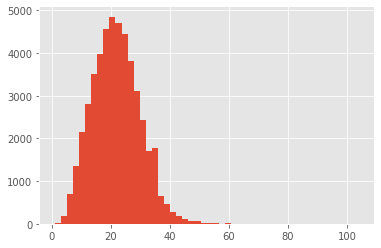

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
print(num_words)

35179


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O']) 
print(y.shape)
y = np.array([to_categorical(i, num_classes=num_tags) for i in y])


(47959, 50)


In [15]:
print(sentences[0])
print(X[0], X[0].shape)
print(y[0], y[0].shape)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]
[ 7088 32508  7839 19828 15929 21718 32546  3477  3250 24363 22263 28997
  5521 13862 32779 24363  8434 32508  6390 31331 22752 34320 30268 26804
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178] (50,)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(38367, 50) (38367, 50, 17)
(9592, 50) (9592, 50, 17)


### Task 6: Build and Compile a Bidirectional LSTM Model

In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [18]:
input_ = Input(shape=(max_len,))
x = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(x)
x = TimeDistributed(Dense(num_tags, activation='softmax'))(x) 

model = Model(inputs=input_, outputs=x)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(optimizer="adam",
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])

### Task 7: Train the Model

In [20]:
#!pip install livelossplot

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [22]:
y_train.shape

(38367, 50, 17)

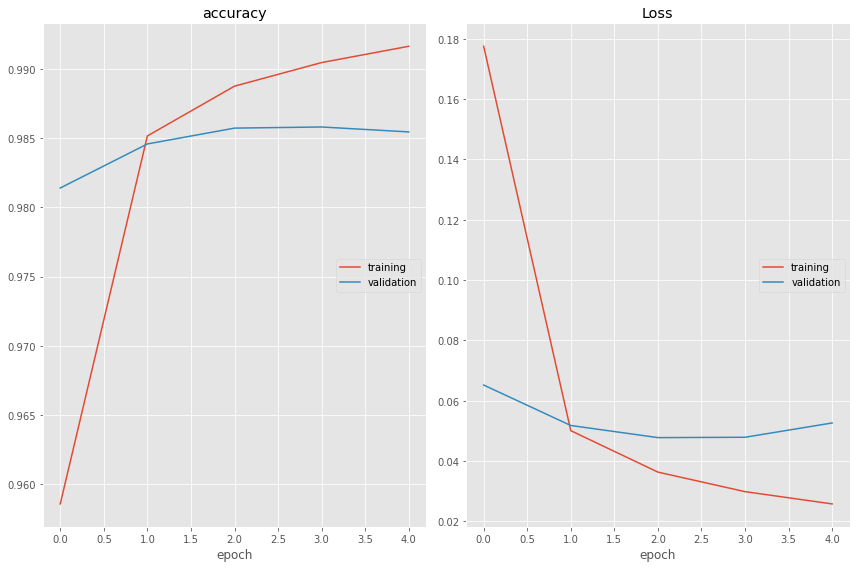

accuracy
	training         	 (min:    0.959, max:    0.992, cur:    0.992)
	validation       	 (min:    0.981, max:    0.986, cur:    0.985)
Loss
	training         	 (min:    0.026, max:    0.178, cur:    0.026)
	validation       	 (min:    0.048, max:    0.065, cur:    0.053)


In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=0, 
                               mode='max',
                               restore_best_weights=False
                              )

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(x_train, y_train, 
                    validation_data=(x_test,y_test),
                    epochs=5, 
                    batch_size=32,
                    verbose=1,
                    callbacks=callbacks
                   ) 

### Task 8: Evaluate Named Entity Recognition Model

In [24]:
model.evaluate(x_test, np.array(y_test))

300/300 [==============================] - 16s 53ms/step - loss: 0.0526 - accuracy: 0.9854


[0.05264874920248985, 0.9854462146759033]

In [25]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('='*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t {}\n'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

The            O	 O

United         B-org	 B-org

Nations        I-org	 I-org

has            O	 O

been           O	 O

under          O	 O

fire           O	 O

for            O	 O

failing        O	 O

to             O	 O

stop           O	 O

ongoing        O	 O

ethnic         O	 O

violence       O	 O

in             O	 O

Ituri          B-geo	 B-geo

.              O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Ganiyu         O	 O

Gan

In [26]:
import spacy
from spacy import displacy

In [27]:
nlp = spacy.load('en_core_web_sm')

In [28]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [29]:
displacy.render(text, style = 'ent', jupyter=True)